In [77]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib, collections
from scipy.stats import norm
import imp, os, pickle
import warnings
from matplotlib import collections  as mc
from scipy.stats import poisson
warnings.filterwarnings("ignore")
from scipy.stats import norm
sns.set(style="white")
colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

## Parameters

In [78]:
f = 0.1 #Mining rate
m = 200 #Number of voting chains
log_epsilon = 20 #Confirmation guarantee
beta_actual = 0.4
prob_selecting_proposer_blocks_by_honest_nodes = [0.4, 0.6] 

## Prism Latency Simulation

In [79]:
# Number of adverserial blocks in private at time t
def adverserial(t, beta, fv):
    x = np.arange(0,1000,1)
    mu = fv*t*beta/(1-beta)
    return poisson.pmf(x, mu)

#Probability that a vote with depth k will be removed when adversary has Z_t blocks in private
def p_k_t(k, Z_t,beta):
    ans = 0
    k = int(k)
    for i in range(k):
        ans += Z_t[i]*np.power(beta/(1-beta), k - i)
    ans += np.sum(Z_t[k:])
    return ans

def runExp(m, log_epsilon, fv):
    events = int(20000*log_epsilon)
    beta_array = np.array([0.1, 0.15, 0.2, 0.25, .3, .35, 0.4])
    time_array_for_list_confirmation = np.zeros_like(beta_array)
    time_array_for_unique_block_confirmation = np.zeros_like(beta_array)
    fv_effective = fv/(1.0+2*fv) #Forking
    exp_random_v = np.random.exponential(1/(m*fv_effective), size=events)
    
    for j, beta in enumerate(beta_array):
#         exponent = 0.8*(1-2*beta)/(1-beta)*np.log((1-beta)/beta)
        
        votes, votes_permanence_E, votes_permanence_V =  np.zeros(m), np.zeros(m),  np.zeros(m)
        time_for_list_confirmation, time_for_unique_block_confirmation, mean, var  = 0, 0,numpy.zeros(2),numpy.zeros(2)
        list_confirmation_done = False # set it True when list confirmation done
        '''
        The following vector contains proposal block voted by each of the voter chain
        Initially, no voter block has been mined and so no voting yet, thus, initializing with None
        If proposal_block_selected_by_voter_chain[rChain] = 0, then vote is for A
        If proposal_block_selected_by_voter_chain[rChain] = 1, then vote is for B
        '''
        proposal_block_selected_by_voter_chain = np.asarray([None]*m) 
        
        print('Beta: {0:8.2f}'.format(beta))
        
        for i, tDiff in enumerate(exp_random_v):
            
            time_for_unique_block_confirmation += tDiff
            
            if list_confirmation_done == False:
                time_for_list_confirmation += tDiff
            
            # randomly selecting a chain to add vote
            rChain = np.random.randint(m, size=1)[0]
            
            '''
            checking whether there are any voter chain yet to vote
            '''
            if np.count_nonzero(proposal_block_selected_by_voter_chain == None) > 0:
                # there are still voter chains that haven't voted yet
                
                mined_by_adversary_or_honest_node = np.random.choice(['Honest', 'Adversary'], 1, p = [1 - beta_actual, beta_actual])
                
                if mined_by_adversary_or_honest_node == 'Honest':
                    # mined block is by an honest user
                    
                    # checking whether the voter chain has voted or not
                    if proposal_block_selected_by_voter_chain[rChain] == None:
                        # Voter hasn't voted yet
                        
                        number_of_votes_for_A_currently = np.count_nonzero(proposal_block_selected_by_voter_chain == 0)
                        number_of_votes_for_B_currently = np.count_nonzero(proposal_block_selected_by_voter_chain == 1)
                        
                        # vote for that proposer block which has highest number of votes
                        if number_of_votes_for_A_currently > number_of_votes_for_B_currently:
                            proposal_block_selected_by_voter_chain[rChain] = 0
                            votes[rChain] += 1
                        elif number_of_votes_for_A_currently < number_of_votes_for_B_currently:
                            proposal_block_selected_by_voter_chain[rChain] = 1
                            votes[rChain] += 1
                        else:
                            proposal_block_selected_by_voter_chain[rChain] = np.random.choice([0, 1], 1, p = prob_selecting_proposer_blocks_by_honest_nodes)
                            votes[rChain] += 1        
                    else:
                        # voter chain has already voted
                        # apply longest chain protocol
                        votes[rChain] += 1
                else:
                    # mined block is by an adversary
                    
                    
                    # checking whether the voter chain has voted or not
                    if proposal_block_selected_by_voter_chain[rChain] == None:
                        # Voter hasn't voted yet
                        
                        number_of_votes_for_A_currently = np.count_nonzero(proposal_block_selected_by_voter_chain == 0)
                        number_of_votes_for_B_currently = np.count_nonzero(proposal_block_selected_by_voter_chain == 1)
                        
                        # Balance attack
                        if number_of_votes_for_A_currently > number_of_votes_for_B_currently:
                            proposal_block_selected_by_voter_chain[rChain] = 1
                            votes[rChain] += 1
                        elif number_of_votes_for_A_currently < number_of_votes_for_B_currently:
                            proposal_block_selected_by_voter_chain[rChain] = 0
                            votes[rChain] += 1
                        else:
                            pass
                    else:
                        # adversary doesn't do anything with chains that have already voted
                        pass
            else:
                # there are no voter chains that haven't voted yet
                # adversary can't influence the voting game anymore with balance attack
                # adversary with capability of balance attack won't mine blocks for such attack
                
                # For honest users, follow longest chain protocol
                # Adding vote on a random chain
                votes[rChain] +=1

            # print('Votes')
            # print(votes)
            #Solidified probability
            Z_t = adverserial(time_for_unique_block_confirmation, beta, fv)
            p_i = 1 - p_k_t(votes[rChain], Z_t, beta)
#             p_i = 1-np.power(np.e, -votes[rChain]*exponent) # Old calculation.


            #Updating the mean and variance
            mean[proposal_block_selected_by_voter_chain[rChain]] -= votes_permanence_E[rChain]
            var[proposal_block_selected_by_voter_chain[rChain]]  -= votes_permanence_V[rChain]
            votes_permanence_E[rChain] = p_i
            votes_permanence_V[rChain] = p_i*(1-p_i)
            mean[proposal_block_selected_by_voter_chain[rChain]] += votes_permanence_E[rChain]
            var[proposal_block_selected_by_voter_chain[rChain]]  += votes_permanence_V[rChain]

            
            underbar_V_A = mean[0] - np.sqrt(2*var[0]*log_epsilon)
            underbar_V_B = mean[1] - np.sqrt(2*var[1]*log_epsilon)
            
            overbar_V_private = m - underbar_V_A - underbar_V_B   
            # print("underbar_V_A: {0:8.2f}".format(underbar_V_A))
            # print("underbar_V_B: {0:8.2f}".format(underbar_V_B))
            # print("overbar_V_private: {0:8.2f}".format(overbar_V_private))
            
            # List confirmation policy
            if max(underbar_V_A, underbar_V_B) > overbar_V_private:
                time_array_for_list_confirmation[j] = time_for_list_confirmation
                list_confirmation_done = True
    
            
        
            
            # counting number of voter chains that haven't cast vote for any proposal block
            U_current = np.count_nonzero(proposal_block_selected_by_voter_chain == None)
            
            # counting number of voter chains that currently casts vote for proposal block A
            V_A_current = np.count_nonzero(proposal_block_selected_by_voter_chain == 0) 
               
            # counting number of voter chains that currently casts vote for proposal block B
            V_B_current = np.count_nonzero(proposal_block_selected_by_voter_chain == 1)           
            

            overbar_V_A = V_A_current + (V_B_current - max(underbar_V_B , 0)) + U_current        
            overbar_V_B = V_B_current + (V_A_current - max(underbar_V_A , 0)) + U_current        
        
            
            # Unique block confirmation
            if (underbar_V_A > overbar_V_B) or (overbar_V_A < underbar_V_B):
                time_array_for_unique_block_confirmation[j] = time_for_unique_block_confirmation
                print('List confirmation at: {0:8.2f}'.format(time_for_list_confirmation))
                print('Unique Block confirmation at: {0:8.2f}'.format(time_for_unique_block_confirmation))
                break
            

    return time_array_for_list_confirmation, time_array_for_unique_block_confirmation

beta_array = np.array([0.1, 0.15, 0.2, 0.25, .3, .35, 0.4])
prism_ans_list_confirmation = np.zeros_like(beta_array)
prism_ans_unique_block_confirmation = np.zeros_like(beta_array)
#T1: Time taken for a unique proposer block to refer the tx_block
prism_ans_list_confirmation += np.power(np.e, 1*f)/f
prism_ans_unique_block_confirmation += np.power(np.e, 1*f)/f

#T2: Time taken for a proposer block to get confirmed
no_exp = 5
for i in range(no_exp):
    temp1, temp2= runExp(m, log_epsilon, f)
    prism_ans_list_confirmation += temp1
    prism_ans_unique_block_confirmation += temp2
prism_ans_list_confirmation /= no_exp
prism_ans_unique_block_confirmation /= no_exp

Beta:     0.10
List confirmation at:    30.61
Unique Block confirmation at:    59.13
Beta:     0.15
List confirmation at:    61.91
Unique Block confirmation at:   109.62
Beta:     0.20
List confirmation at:    83.40
Unique Block confirmation at:   138.21
Beta:     0.25
List confirmation at:   112.61
Unique Block confirmation at:   195.04
Beta:     0.30
List confirmation at:   131.97
Unique Block confirmation at:   299.76
Beta:     0.35
List confirmation at:   344.94
Unique Block confirmation at:   637.20
Beta:     0.40
List confirmation at:   680.96
Unique Block confirmation at:  1439.78
Beta:     0.10
List confirmation at:    32.19
Unique Block confirmation at:    80.64
Beta:     0.15
List confirmation at:    44.88
Unique Block confirmation at:    91.65
Beta:     0.20
List confirmation at:    65.18
Unique Block confirmation at:   111.83
Beta:     0.25
List confirmation at:   115.63
Unique Block confirmation at:   196.09
Beta:     0.30
List confirmation at:   158.07
Unique Block confir

## Bitcoin Latency calculation

In [80]:
exponent = 0.8*(1-2*beta_array)/(1-beta_array)*np.log((1-beta_array)/beta_array)
bitcoin_ans= (log_epsilon+np.log2(150))/(exponent*f)

## Plot

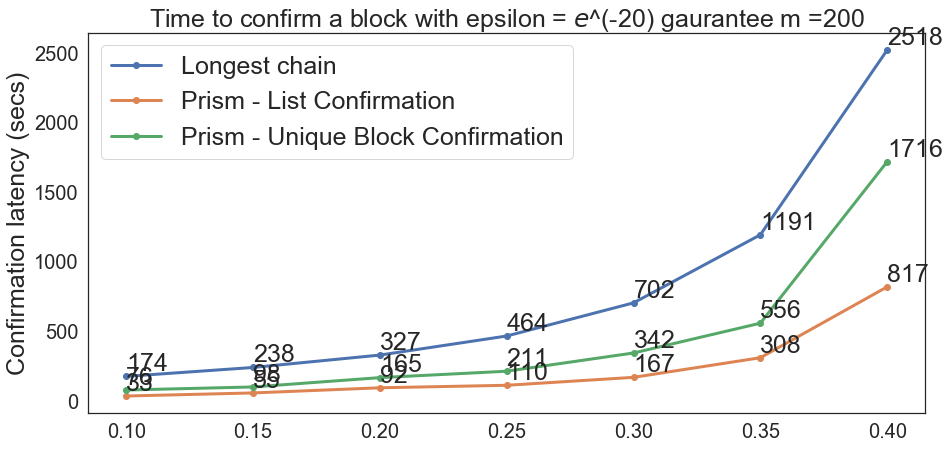

In [81]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)

bitcoin_ans = bitcoin_ans.astype(int)
prism_ans_list_confirmation = prism_ans_list_confirmation.astype(int)
prism_ans_unique_block_confirmation = prism_ans_unique_block_confirmation.astype(int)
plt.plot(beta_array, bitcoin_ans, '-o', lw=3, label="Longest chain")
plt.plot(beta_array, prism_ans_list_confirmation, '-o',lw=3, label="Prism - List Confirmation")
plt.plot(beta_array, prism_ans_unique_block_confirmation, '-o',lw=3, label="Prism - Unique Block Confirmation")
for i in range(bitcoin_ans.shape[0]):
    ax.annotate(bitcoin_ans[i],xy=(beta_array[i],bitcoin_ans[i]+40), size=25)
    ax.annotate(prism_ans_list_confirmation[i],xy=(beta_array[i],prism_ans_list_confirmation[i]+40), size=25)
    ax.annotate(prism_ans_unique_block_confirmation[i],xy=(beta_array[i],prism_ans_unique_block_confirmation[i]+40), size=25)
plt.ylabel("Confirmation latency (secs)", size=25)
# plt.xlabel("Beta", size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title("Time to confirm a block with epsilon = $e$^("+str(-log_epsilon)+") gaurantee m ="+str(m), size=25)
plt.legend(prop={'size': 25})
plt.show()


In [29]:
import numpy
a = numpy.asarray([0]*10)
print(numpy.count_nonzero(a==None))
b = numpy.random.randint(10, size = 1)[0]
print(b)

0
4
